In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

The aim of the following functions is to create an artificial dataset to test decision tree classification algorithm. Each class will consist of instances belonging to a 'hollow' hyper-sphere or 'shell'. All shells will have the same radius and the same 'thickness'. Instances belonging to different classes will lie within shells with different centres. The centres will have coordinates like [0, 0, 0], [1, 1, 1], [2, 2, 2] ... [n, n, n] for n classes in 3 dimensions for example.
To make things more challenging for the classifiers the feature space will also contain a number of dimensions where the information is not correlated with the class, i.e. it will be distributed according to an identical normal distribution for all classes.
To build the function make_dataset that generates the multiclass dataset you will make use of an auxiliary function make_shell to generate points within a given shell.
In turn, build the function make_shell you will make use of an auxiliary function rescale_within_shell that will 'rescale' an instance in input so to guarantee that it will lie within the desired distance range.


In [2]:
def rescale_within_shell(x, radius, thickness):
    sum=0
    for i in x:
        sum+=i*i
    sum=sum**0.5
    d=np.random.uniform(radius-thickness,radius+thickness)
    return x*d/sum

def make_shell(centre, radius, thickness, n_instances):
    X=np.zeros((n_instances,len(centre)))
    
    for n in range(n_instances):
        v=[]
        for i in range(len(centre)):
            v.append(np.random.uniform(-1,1))
        v=np.array(v)    
        u=rescale_within_shell(v, radius, thickness)
        X[n]=u+centre
    return X

def make_dataset(nclasses, ndim, ndim_noninformative, n_instances_list, radius, thickness):
    n=sum(n_instances_list)
    #gaussian distribution
    mu, sigma = 0.0, 1.0
    temp=np.zeros((n,ndim_noninformative))
    for i in range(n):
        s = np.random.normal(mu, sigma, ndim_noninformative)
        temp[i]=s
        
    X=np.zeros((1,ndim))
    #y array
    y=[]
    for i in range(nclasses):
        for j in range(n_instances_list[i]):
            y.append(i)
    y=np.array(y)
    
    #create instances
    for i in range(nclasses):
        centre=[i for k in range(ndim)]
        v=make_shell(centre, radius, thickness, n_instances_list[i])
        X=np.vstack((X,v))
    X = np.delete(X, (0), axis=0)    
    X=np.hstack((X,temp))
    y=y.astype(np.int64)       
    return (X,y)  

def plot(X, y, id_axis_1=0,id_axis_2=1):
    fig = plt.figure(figsize=[6, 6])
    ax = fig.gca()
    ax.scatter(X[:,id_axis_1], X[:,id_axis_2], c=y)
    plt.grid()
    plt.show()

Create the dataset using the above functions

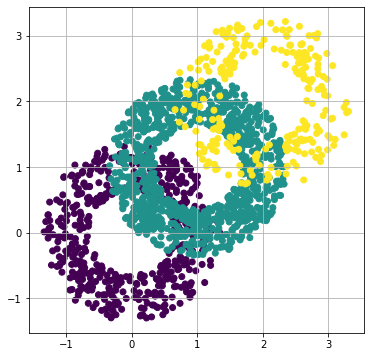

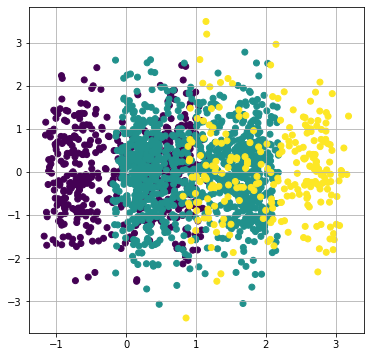

In [3]:
X,y = make_dataset(nclasses=3, ndim=2, ndim_noninformative=2, n_instances_list=[500, 1000, 250], radius=1, thickness=.35)
plot(X,y)

X,y = make_dataset(nclasses=3, ndim=2, ndim_noninformative=2, n_instances_list=[500, 1000, 250], radius=1, thickness=.2)
plot(X,y,id_axis_1=1,id_axis_2=2)

The aim of the following functions is to be able to partition a dataset into folds according to the cross validation procedure. If we ask for a 5 fold cross validation, for example, we should generate 5 training sets and 5 test sets. Each one of those data set will be formed by a data matrix and a corresponding target vector.

In [4]:
def shuffle(X,y):
    y=np.reshape(y,(-1,1))
    temp=np.hstack((X,y))
    np.random.shuffle(temp)
    Xp,yp=np.hsplit(temp,[-1])
    yp=yp.flatten()
    yp=yp.astype(np.int64)
    return Xp,yp

def make_train_test_ids_for_fold_i(n_elements, k, fold_i):
    sample_list=[i for i in range(n_elements)]
    split=np.array_split(sample_list,k)
    result=[]
    for i in split:
        result.append(list(i))
    
    test_ids=result[fold_i]
    test_ids=np.array(test_ids)
    result.pop(fold_i)
    train_ids = []
    [train_ids.extend(list) for list in result]
    train_ids=np.array(train_ids)
    return (train_ids,test_ids)

def make_cv(X,y, k = 5):
    y=np.reshape(y,(-1,1))
    temp=np.hstack((X,y))
    list1=[]
    j=0
    temp=temp[temp[:, -1].argsort()]
    #separate the classes
    for i in range(1,len(X)):
        if temp[i-1][-1]!=temp[i][-1]:
            arr=temp[j:i,:]
            j=i
            list1.append(arr)
    list1.append(temp[j:,:])  
   
    trn=[]
    tst=[]
    #find the k fold training and test sets
    for i in range(len(list1)):
        n_elements=len(list1[i])
        arr=list1[i]
        np.random.shuffle(arr)
        train_list=[]
        test_list=[]
        for j in range(k):
            tr_id,ts_id=make_train_test_ids_for_fold_i(n_elements, k, j)
            tr=tr_id.tolist()
            ts=ts_id.tolist()
            train=arr[tr,:]
            test=arr[ts,:]
            train_list.append(train)
            test_list.append(test)
        trn.append(train_list)
        tst.append(test_list)
        
    arr1=np.array(trn)
    arr2=np.array(tst)
    list4=[]
    for j in range(k):
        arr3=np.zeros((1,arr1[0][0].shape[1]))
        for i in range(len(arr1)):
            arr3=np.vstack((arr3,arr1[i][j]))
        arr3=np.delete(arr3,(0),axis=0)
        list4.append(arr3)
    list5=[]
    for j in range(k):
        arr3=np.zeros((1,arr2[0][0].shape[1]))
        for i in range(len(arr2)):
            arr3=np.vstack((arr3,arr2[i][j]))
        arr3=np.delete(arr3,(0),axis=0)
        list5.append(arr3)
    
    train_X_fold=[]
    train_Y_fold=[]
    test_X_fold=[]
    test_Y_fold=[]
    
    for i in range(k):
        arr4=list4[i]
        arr5=list5[i]
        x_temp,y_temp=np.hsplit(arr4,[-1])
        y_temp=y_temp.flatten()
        y_temp=y_temp.astype(np.int64)
        x_p,y_p=shuffle(x_temp,y_temp)
        train_X_fold.append(x_p)
        train_Y_fold.append(y_p)
        x_temp,y_temp=np.hsplit(arr5,[-1])
        y_temp=y_temp.flatten()
        y_temp=y_temp.astype(np.int64)
        x_p,y_p=shuffle(x_temp,y_temp)
        test_X_fold.append(x_p)
        test_Y_fold.append(y_p)
        
        
    return (train_X_fold,train_Y_fold,test_X_fold,test_Y_fold)

The aim of the following functions is to compute the predictive performance of classifier.

In [5]:

import statistics
def confusion_matrix(targets, preds):
    t_list=targets.tolist()
    p_list=preds.tolist()
    classes= list(set(t_list))
    
    Matrix=np.zeros((len(classes),len(classes)))
    
    for i in range(len(t_list)):
        if t_list[i]==p_list[i]:
            Matrix[t_list[i]][t_list[i]]+=1
        else:
            Matrix[t_list[i]][p_list[i]]+=1
    Matrix=Matrix.astype(np.int64)
    return Matrix


def performace_estimate(X, y, k, n_rep, fit_func, score_func, params):
    mean_errors=[]
    std_errors=[]
    for i in range(len(params)):
        param=params[i]
        scores=[]
        for j in range(n_rep):
            train_X_fold,train_Y_fold,test_X_fold,test_Y_fold=make_cv(X,y,k)
            for fold in range(k):
                train_data=train_X_fold[fold]
                train_Y=train_Y_fold[fold]
                test_data=test_X_fold[fold]
                test_Y=test_Y_fold[fold]
                model=fit_func(train_data,train_Y,param)
                sc=score_func(test_data,test_Y,model)
                scores.append(1-sc)
        mean_errors.append(statistics.mean(scores))
        std_errors.append(statistics.stdev(scores))
    mean_errors=np.array(mean_errors)
    std_errors=np.array(std_errors)
    return (mean_errors,std_errors)

Below functions are helper functions for decision tree calssifier

In [7]:
import collections
import random
    
def gini_score(targets):
    gini=0
    counts=collections.Counter(targets)
    freq=list(counts.values())
    tot=sum(freq)
    freq=np.array(freq)
    freq=freq/tot
    for f in freq:
        gini+=(f*(1-f))
    return gini

def partition(data_matrix, targets, feature_id, threshold):
    data_matrix_right=[]
    data_matrix_left=[]
    targets_right=[]
    targets_left=[]
    
    for i in range(len(data_matrix)):
        if data_matrix[i][feature_id]<threshold:
            arr=data_matrix[i]
            arr1=targets[i]
            data_matrix_left.append(arr)
            targets_left.append(arr1)
        else:
            arr=data_matrix[i]
            arr1=targets[i]
            data_matrix_right.append(arr)
            targets_right.append(arr1)
    data_matrix_right=np.array(data_matrix_right)
    data_matrix_left=np.array(data_matrix_left)
    targets_right=np.array(targets_right,dtype='int64')
    targets_left=np.array(targets_left,dtype='int64')
    return data_matrix_right, data_matrix_left, targets_right, targets_left
    
def goodness_of_split(data_matrix, targets, feature_id, threshold):
    g_d=gini_score(targets)
    dm_r,dm_l,t_r,t_l=partition(data_matrix, targets, feature_id, threshold)
    g_l=gini_score(t_l)
    g_r=gini_score(t_r)
    n=len(data_matrix)
    f_r=len(dm_r)/n
    f_l=len(dm_l)/n
    
    quality=g_d-f_l*g_l-f_r*g_r
    return quality
    
def sample_feature_id_threshold(data_matrix):
    rows,cols=data_matrix.shape
    feature_id=random.randint(0, cols-1)
    arr=data_matrix[:,feature_id]
    min_idx=np.argsort(arr)[0]
    max_idx=np.argsort(arr)[-1]
    max_val=arr[max_idx]
    min_val=arr[min_idx]
    threshold=np.random.uniform(min_val,max_val)
    return feature_id,threshold
    
    
def select_best_split(data_matrix, targets, n_attempts):
    g_list=np.zeros((n_attempts))
    f_ids=np.zeros((n_attempts),dtype='int64')
    thresh=np.zeros((n_attempts))
    
    for i in range(n_attempts):
        f,t=sample_feature_id_threshold(data_matrix)
        f_ids[i]=f
        thresh[i]=t
        g=goodness_of_split(data_matrix, targets, f, t)
        g_list[i]=g
    idx=np.argsort(g_list)[-1]
    feature_id=f_ids[idx]
    threshold=thresh[idx]
    return feature_id,threshold

Following functions implement a decision tree classifier algorithm for classification tasks from scratch

In [8]:

import collections
def split_further(dm,targets,n_attempts, max_depth, min_size,depth,n_classes):
    size=len(targets)
    g_score=gini_score(targets)
    
    if g_score==0 or depth>=max_depth or size<min_size:
        dic=np.zeros(n_classes)
        counts=collections.Counter(targets)
        vals=list(counts.values())
        keys=list(counts.keys())
        for i in range(len(keys)):
            idx=keys[i]
            dic[idx]=vals[i]
        tot=np.sum(dic)
        dic=dic/tot
    else:
        depth+=1
        feature_id,threshold=select_best_split(dm, targets, n_attempts)
        dm_r,dm_l,t_r,t_l=partition(dm, targets, feature_id, threshold)
        dic={
            'feature_id':feature_id,
            'threshold':threshold,
            'right':split_further(dm_r,t_r,n_attempts,max_depth, min_size,depth,n_classes),
            'left':split_further(dm_l,t_l,n_attempts,max_depth, min_size,depth,n_classes)
        } 
        
    return dic


def fit_decision_tree(data_matrix, targets, n_attempts, max_depth, min_size):
    depth=1
    n_classes= len(np.unique(targets, return_counts=False))
    feature_id,threshold=select_best_split(data_matrix, targets, n_attempts)
    dm_r,dm_l,t_r,t_l=partition(data_matrix, targets, feature_id, threshold)
    model={
        'feature_id':feature_id,
        'threshold':threshold,
        'right':split_further(dm_r,t_r,n_attempts,max_depth, min_size,depth,n_classes),
        'left':split_further(dm_l,t_l,n_attempts,max_depth, min_size,depth,n_classes)
    }
    return model

def get_probab(model,arr):
    if isinstance(model, dict):
        threshold=model['threshold']
        feature_id=model['feature_id']
        if arr[feature_id]<threshold:
            mod=model['left']
            probab=get_probab(mod,arr)
        else:
            mod=model['right']
            probab=get_probab(mod,arr) 
    else:
        probab=model
    
    return probab
def predict_proba_decision_tree(data_matrix, model):
    proba_preds=[]
    for i in range(len(data_matrix)):
        arr=data_matrix[i]
        threshold=model['threshold']
        feature_id=model['feature_id']
        if arr[feature_id]<threshold:
            mod=model['left']
            probab=get_probab(mod,arr)
        else:
            mod=model['right']
            probab=get_probab(mod,arr) 
        proba_preds.append(probab)
    proba_preds=np.array(proba_preds)
    return proba_preds
    
def predict_decision_tree(data_matrix, model):
    proba_preds=predict_proba_decision_tree(data_matrix, model)
    preds=[]
    for i in range(len(data_matrix)):
        arr=proba_preds[i]
        preds.append(np.argsort(arr)[-1])
    preds=np.array(preds,dtype='int64')
    return preds

def score_decision_tree(data_matrix, targets, model):
    preds=predict_decision_tree(data_matrix, model)
    confusion_mat=confusion_matrix(targets, preds)
    TP=np.trace(confusion_mat)
    Tot=np.sum(confusion_mat)
    score=TP/Tot
    return score

Checkpoint for the decision tree implementation and plot error

<ipython-input-4-aad2ebe6348d>:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr1=np.array(trn)
<ipython-input-4-aad2ebe6348d>:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr2=np.array(tst)


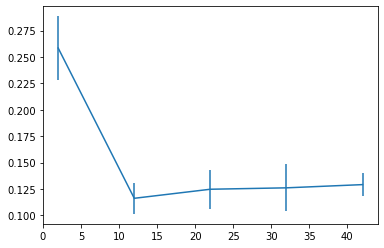

In [9]:
def fit_decision_tree_max_depth(data_matrix, targets, param):
    return fit_decision_tree(data_matrix, targets, n_attempts=10, max_depth=param, min_size=2)

X,y = make_dataset(nclasses=3, ndim=3, ndim_noninformative=2, n_instances_list=[500, 1000, 250], radius=1, thickness=.3)
params = np.arange(2,50,10)
mean_errors, std_errors = performace_estimate(X,y,k=5, n_rep=3, fit_func=fit_decision_tree_max_depth, score_func=score_decision_tree, params=params)
plt.errorbar(params, mean_errors, std_errors);